## **ASSIGNMENT 3**
# Instructor: Gianfranco Doretto
# Due: Nov 3, 2023 by the end of the day
# Student Name: Ali Zafari

The assignment is composed of three sections and a bonus point section.

The first one is related to calibration, and requires you to find the projection matrix from 3D to 2D points. The second section requires you to implement the 8-point algorithm to calculate the Fundamental mapping matrix.
The third section is related to finding the 3D points from 2D points and camera matrices -this process is called Triangulation. The last bonus section is related to dense 3D reconstruction.

**Submission Instructions**

You will need to prepare a folder called

```hw3_YOUR-LAST-NAME_YOUR-FIRST-NAME```

In that folder you want to put
- Your Colab notebook (fill out the Student Name above)
- For every question that requires submitting data you create a subfolder called ```question_NUMBER``` and you put there the files with adequate naming. If we do not understand that something is there you will not get credit!

You will need to zip the folder and you will need to submit the zip file ```hw3_YOUR-LAST-NAME_YOUR-FIRST-NAME.zip``` to the instructor by sharing the file via Google Drive.

In order to [share a file](https://support.google.com/drive/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop) with the instructor please use this email gidoretto@mix.wvu.edu

During the evaluation we are going to test your Python notebook with Google Colab. So, the assumption is that you are going to do all the development with Colab. We will run your notebook by running the cells sequentially. They will have to produce the expected result in order for you to get credit.

**Submission Helper**

We have put color coded text to make it easier for you to distinguish between types of submission.

<font color='red'>[CODE]</font> tag for a submission requires you to code.

<font color='blue'>[ANSWER]</font> tag for a submission requires you to write something (including math where needed).

<font color='green'>[DATA]</font> tag for a submission requires you to submit corresponding file. This will mostly include image files or graph plot files.

In [ ]:
# Mount your MIX Google Drive
import os
drive_mount = ""

# You need to mount your Google drive if you are using Collab. No need to execute below three line if you are not using Collab, simply comment out the lines.
from google.colab import drive
drive_mount = "/content/drive"
drive.mount(drive_mount)

# TODO: Set your path to the assignment's image folder
dir_path = "/MyDrive/CV-fall23/assignment3/"
global source
source = drive_mount+dir_path
print(os.listdir(source))

Mounted at /content/drive
['Data', 'CS678_Assignment_3.ipynb']


#### Instruction for loading data
1. Make sure you have set the variable **source** in the above block.
2. To get the full path of a file use `os.path.join(source, "<name_of_the_file>")`.
3. For image loading you can use `cv2.imread()` or other libraries.
4. For `.npy` or `.npz` files, use `np.load()`

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Installing open3d module
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nbf

In [ ]:
import open3d

In [ ]:
# Helper Methods

def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2


def draw_epipolar(img1, img2, F, pts1, pts2):
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

    plt.subplot(121)
    plt.imshow(img5)
    plt.subplot(122)
    plt.imshow(img3)
    plt.show()


def visualize_pcd(points):
    """
    Visualize the point cloud.
    """
    pcd = open3d.PointCloud()
    pcd.points = open3d.Vector3dVector(points)
    # Uncommend this line if you want to paint some color
    # pcd.paint_uniform_color([0, 0, 1])
    open3d.draw_geometries([pcd])

# 1. Camera Calibration [20 pts]

The goal is to compute the projection matrix $P$ that goes from world 3D coordinates to 2D image coordi-nates. Recall that using homogeneous coordinates the equation for moving from 3D world to 2D camera coordinates is:

$$
\begin{align}
\begin{pmatrix}
u\\
v\\
1
\end{pmatrix} \equiv P \begin{pmatrix} X \\ Y \\ Z \\ 1 \end{pmatrix}
\end{align}
$$

In part 1, you’re given corresponding point locations in `data/pts2d-norm-pic.txt` and `data/pts3d-norm.txt`, which corresponds to a camera projection matrix.

<font color='blue'>[ANSWER]</font> 1a. Solve the projection matrix P *(use LaTex).* [10 pts]

*Answer*

\begin{equation}
\begin{bmatrix}
u_i \\
v_i \\
1
\end{bmatrix}
≡ \begin{bmatrix}
p_{11} & p_{12} & p_{13} & p_{14} \\
p_{21} & p_{22} & p_{23} & p_{24} \\
p_{31} & p_{32} & p_{33} & p_{34} \\
p_{41} & p_{42} & p_{43} & p_{44}
\end{bmatrix}
\begin{bmatrix}
X_i \\
Y_i \\
Z_i \\
1
\end{bmatrix}
\end{equation}

Equivalent relation in Homogeneous coordinates with arbitrary $c$:
\begin{equation}
\begin{bmatrix}
u_i \\
v_i \\
1
\end{bmatrix}
=
\begin{bmatrix}
u_i*c \\
v_i*c \\
c
\end{bmatrix}
\end{equation}

Multiplyting the $P$ matrix we have:
\begin{equation}
u_i = \frac{p_{11}X_i + p_{12}Y_i + p_{13}Z_i + p_{14}}{p_{31}X_i + p_{32}Y_i + p_{33}Z_i + p_{34}}\\
\end{equation}

\begin{equation}
v_i = \frac{p_{21}X_i + p_{22}Y_i + p_{23}Z_i + p_{24}}{p_{31}X_i + p_{32}Y_i + p_{33}Z_i + p_{34}}\\
\end{equation}
where
\begin{equation}
c = p_{31}X_i + p_{32}Y_i + p_{33}Z_i + p_{34}\\
\end{equation}

To write equations in terms of $p_{ij}$:

\begin{equation}
u_ip_{31}X_i + u_ip_{32}Y_i + u_ip_{33}Z_i + u_ip_{34} - (p_{11}X_i + p_{12}Y_i + p_{13}Z_i + p_{14}) = 0\\
\end{equation}

\begin{equation}
v_ip_{31}X_i + v_ip_{32}Y_i + v_ip_{33}Z_i + v_ip_{34} - (p_{21}X_i + p_{22}Y_i + p_{23}Z_i + p_{24}) = 0\\
\end{equation}

Representing in the matrix form of A**p** = 0,

\begin{equation}
\begin{bmatrix}
X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -u_iX_i & -u_iY_i & -u_iZ_i & -u_i \\
0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -v_iX_i & -v_iY_i & -v_iZ_i & -v_i
\end{bmatrix}
\begin{bmatrix}
p_{11} \\ p_{12} \\ p_{13} \\ p_{14} \\ p_{21} \\ p_{22} \\ p_{23} \\ p_{24} \\ p_{31} \\ p_{32} \\ p_{33} \\ p_{34} \\ p_{41} \\ p_{42} \\ p_{43} \\ p_{44}
\end{bmatrix} =
\begin{bmatrix}
0 \\ 0 \\ ⋯ \\ 0
\end{bmatrix}_{2n\times1}
\end{equation}

Solution of the above system of equations can be found by minimizing ||A**p**||<sub>2</sub> which is the smallest eigenvector of A<sup>T</sup>A.

Projection matrix of the given points will be:
\begin{equation}
P =
\begin{bmatrix}
  0.45827554 & -0.29474237 & -0.01395746 & 0.0040258\\
  -0.05085589 & -0.0545847 & -0.54105993 & -0.05237592\\
  0.10900958 & 0.17834548 & -0.04426782 & 0.5968205
\end{bmatrix}
\end{equation}


<font color='red'>[CODE]</font> 1b. Complete the implementation below [10 pts]

In [ ]:
# TODO: Complete the function below

'''
For given a given set of 2D and 3D points, calculate the projection matrix and return it.
'''
def ProjectionMatrixCalc(two2D,Three3D):
    Three3D = np.hstack((Three3D, np.ones((Three3D.shape[0], 1))))

    zero = np.zeros((4))

    for i in range(0, Three3D.shape[0]):
      r1 = np.hstack((Three3D[i], zero, -two2D[i][0]*Three3D[i]))
      r2 = np.hstack((zero, -Three3D[i], two2D[i][1]*Three3D[i]))

      if i == 0:
        X = np.vstack((r1, r2))
      else:
        X = np.vstack((X, r1, r2))

    _, _, v = np.linalg.svd(X)
    P = v.T[:, -1].reshape((3, 4))

    return P

In [ ]:
f = open(os.path.join(source, 'Data/pts2d-norm-pic.txt'), 'r')

two_d = []
three_d = []

for record in f:
  x, y = record.strip('\n').split()
  two_d.append([x, y])
f.close()


f = open(os.path.join(source, 'Data/pts3d-norm.txt'), 'r')

for record in f:
  x, y, z = record.strip('\n').split()
  three_d.append([x, y, z])

f.close()

P = ProjectionMatrixCalc(np.array(two_d, dtype=float), np.array(three_d, dtype=float))

print(P)

[[ 0.45827554 -0.29474237 -0.01395746  0.0040258 ]
 [-0.05085589 -0.0545847  -0.54105993 -0.05237592]
 [ 0.10900958  0.17834548 -0.04426782  0.5968205 ]]


# 2. Estimation of Fundamental Matrix [40 pts]

The next part of this project is estimating the mapping of points in one image to lines in another by means of the fundamental matrix. This will require you to use similar methods to those in part 1. You’ll work on
the Wizarding Temple dataset

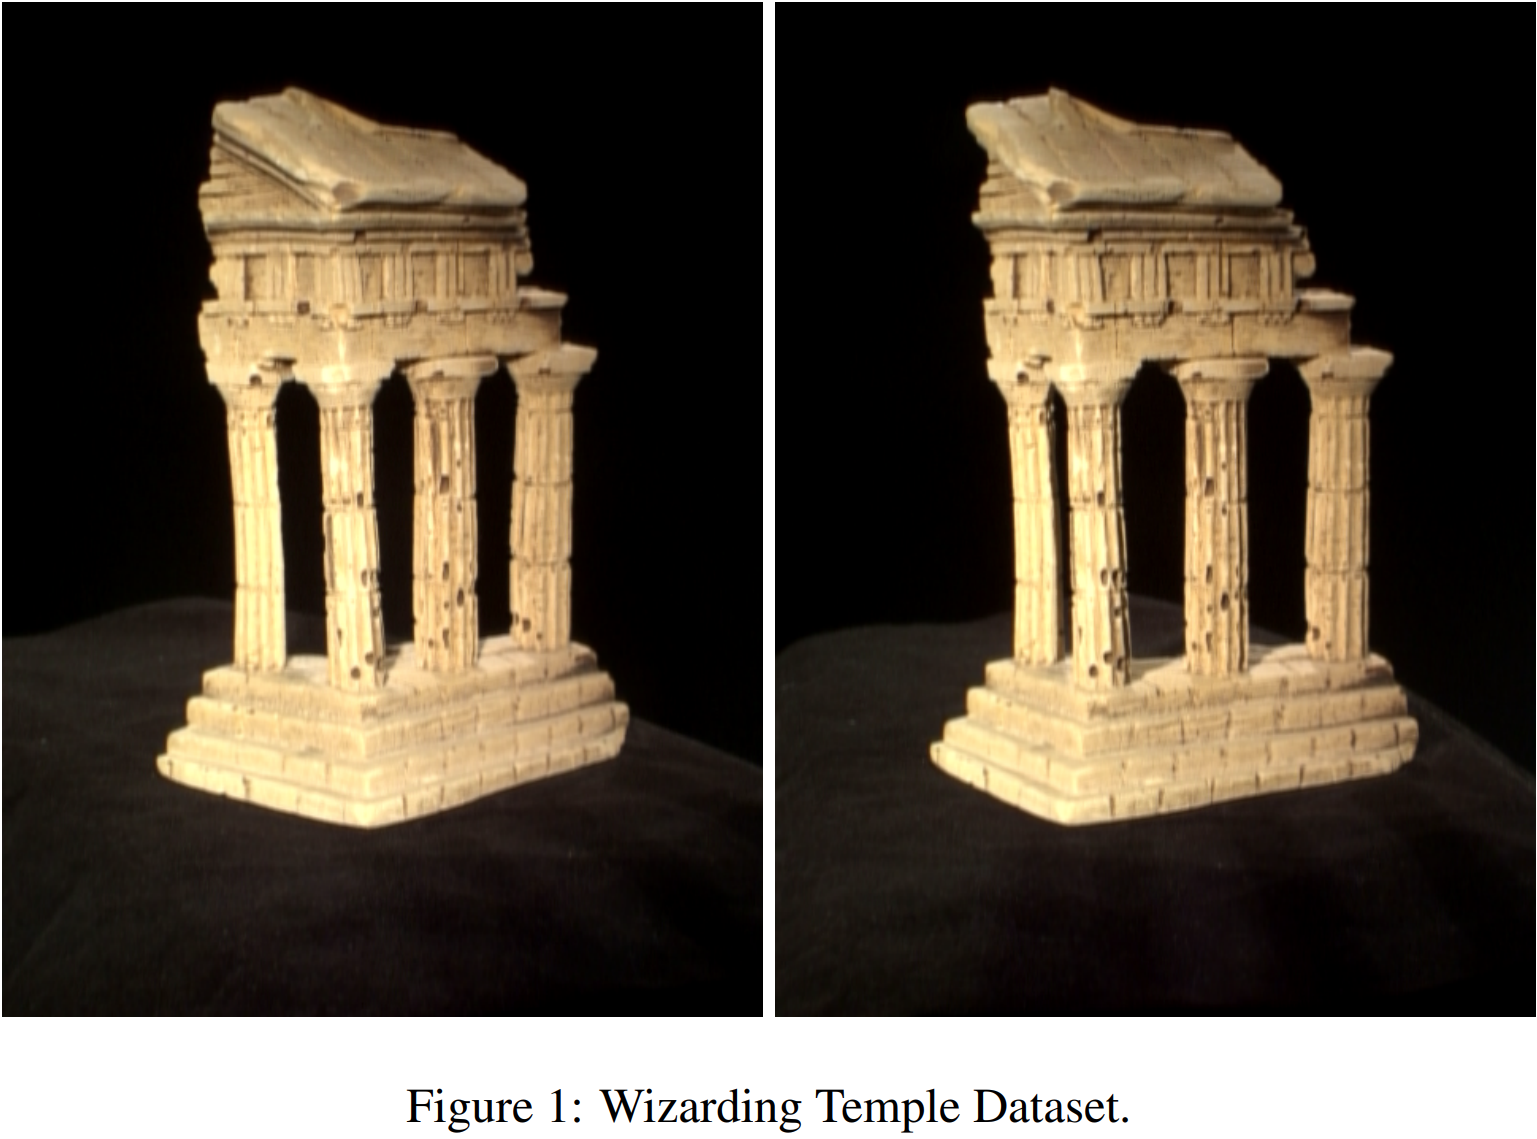

Recall that the definition of the Fundamental Matrix is:

$$
\begin{align}
\begin{pmatrix}
u' & v' & 1
\end{pmatrix} \begin{pmatrix} f_{11} & f_{12} & f_{13} \\ f_{21} & f_{22} & f_{23} \\ f_{31} & f_{32} & f_{33} \end{pmatrix} \begin{pmatrix} u \\ v \\ 1 \end{pmatrix} = 0
\end{align}
$$

Note: the fundamental matrix is sometimes defined as the transpose of the above matrix with the left and right image points swapped. Both are valid fundamental matrices, but the visualization functions in the helper methods assume you use the above form.

And another way of writing this matrix equations is:

\begin{align}
\begin{pmatrix}
u' & v' & 1
\end{pmatrix} \begin{pmatrix} f_{11}u + f_{12}v + f_{13} \\ f_{21}u + f_{22}v + f_{23} \\ f_{31}u + f_{32}v + f_{33} \end{pmatrix} = 0
\end{align}


Which is same as:

$$
\begin{align}
f_{11}uu' + f_{12}vu' + f_{13}u' + f_{21}uv' + f_{22}vv' + f_{23}v' + f_{31}u + f_{32}v + f_{33} = 0
\end{align}
$$

Given corresponding points you get one equation per point pair. Therefore, you can solve this with 8 or more points by constructing a system

$$
\begin{align}
Af = 0
\end{align}
$$

where

$$
\begin{align}
f = \begin{bmatrix} f_{11}, f_{12}, f_{13}, f_{21}, f_{22}, f_{23}, f_{31}, f_{32}, f_{33} \end{bmatrix}^T
\end{align}
$$

and you can use SVD to solve it.

Hints:

1. Load corresponding points from `temple.npz`.
2. Implement eight-point algorithm and estimate the fundamental matrix F. Report F in your report. Remember to normalize F so that the last entry of F is 1.

*Hint:* You may find it helpful to normalize the data first. For example, scale the data by dividing each coordinate by the maximum of the images width and height.

<font color='red'>[CODE]</font> 1. Complete the function `eightPointAlg`. [25 pts]

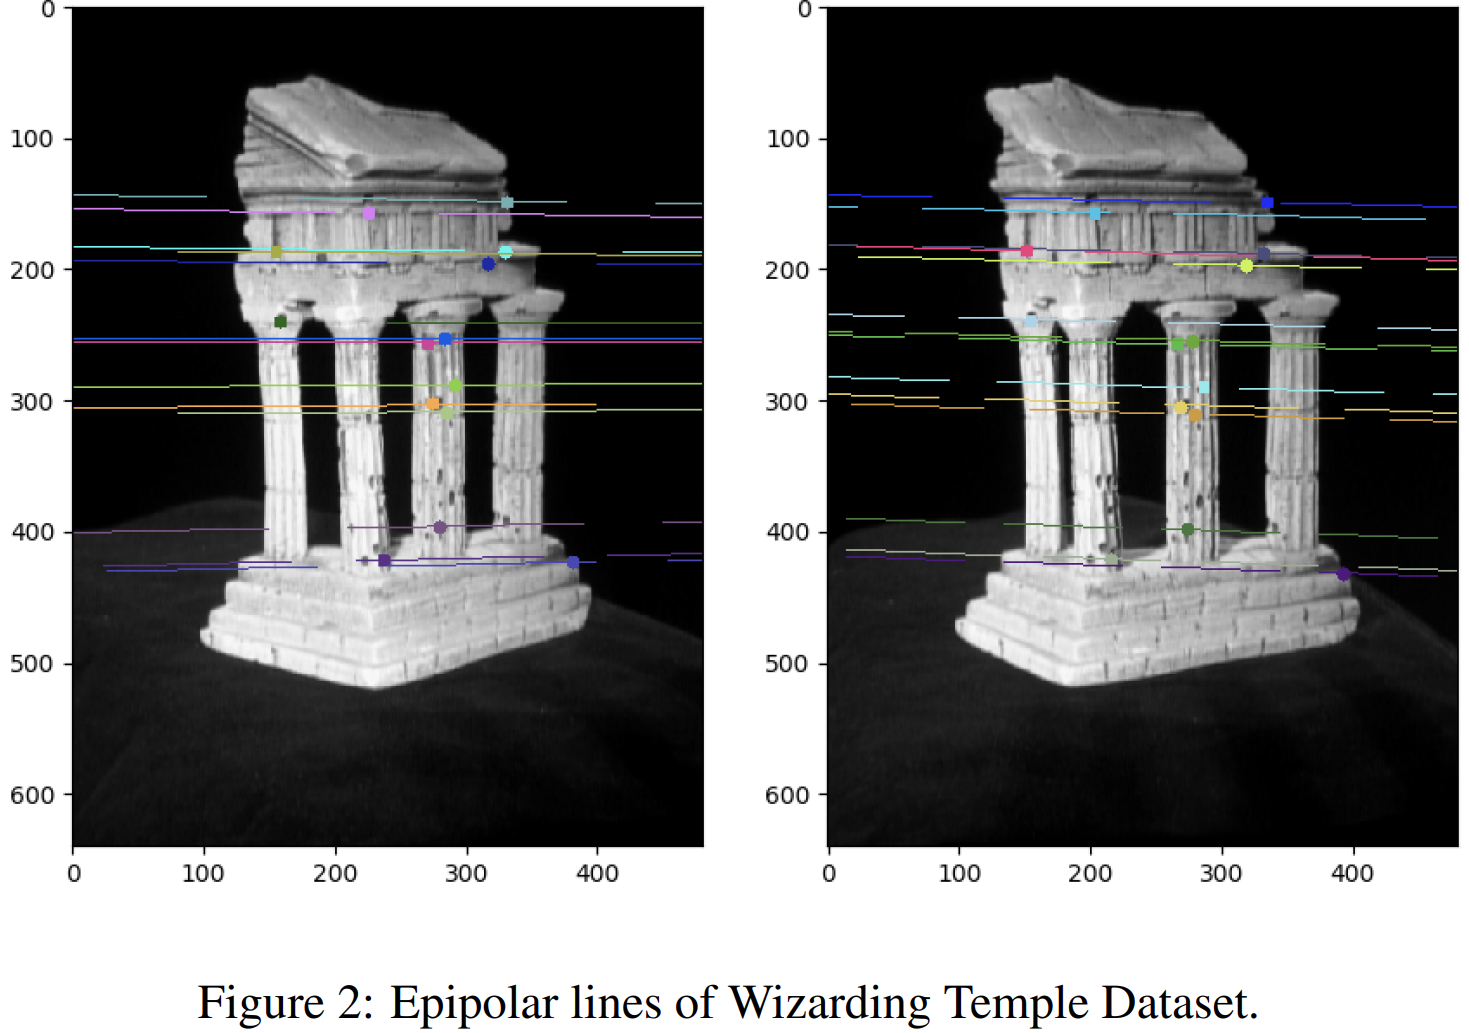

In [ ]:
'''
Implement eight-point algorithm and estimate the fundamental matrix F. Print out F below as well.
Remember to normalize F so that the last entry of F is 1. Hint: You may find it helpful to normalize
the data first. For example, scale the data by dividing each coordinate by the maximum of the images
width and height.
'''
def eightPointAlg(p1, p2): # Feel free to add as many input arguments as you like.
    total_points = len(p1)

    p1_mean = p1.mean(axis=0)
    p2_mean = p2.mean(axis=0)

    s1 = (total_points*2**0.5) / (np.sum(((p1[:, 0] - p1_mean[0])**2 + (p1[:, 1] - p1_mean[1])**2)**0.5))
    s2 = (total_points*2**0.5) / (np.sum(((p2[:, 0] - p2_mean[0])**2 + (p2[:, 1] - p2_mean[1])**2)**0.5))

    T1 = np.array([[s1, 0, -p1_mean[0]*s1], [0, s1, -p1_mean[1]*s1], [0, 0, 1]])
    T2 = np.array([[s2, 0, -p2_mean[0]*s2], [0, s2, -p2_mean[1]*s2], [0, 0, 1]])

    p1_normed = np.dot(T1, np.hstack((p1, np.ones((len(p1), 1)))).T).T
    p2_normed = np.dot(T2, np.hstack((p2, np.ones((len(p2), 1)))).T).T

    A = np.zeros((total_points, 9))

    for i, (pt1, pt2) in enumerate(zip(p1_normed, p2_normed)):
      A[i, 0] = pt1[0] * pt2[0]
      A[i, 1] = pt1[1] * pt2[0]
      A[i, 2] = pt2[0]
      A[i, 3] = pt1[0] * pt2[1]
      A[i, 4] = pt1[1] * pt2[1]
      A[i, 5] = pt2[1]
      A[i, 6] = pt1[0]
      A[i, 7] = pt1[1]
      A[i, 8] = 1

    _, _, vt = np.linalg.svd(A)
    F = (vt.T[:, -1]).reshape((3,3))
    u, d, vt2 = np.linalg.svd(F)
    d = np.diag(d)
    d[2,2] = 0

    F = u @ d @ vt2
    F = T2.T @ F @ T1
    F = F / F[2,2]

    return F

In [ ]:
img1 = cv2.imread(os.path.join(source, 'Data/im1.png'), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(source, 'Data/im2.png'), cv2.IMREAD_GRAYSCALE)

with np.load(os.path.join(source, 'Data/temple.npz')) as temple_pts:
  pts1 = temple_pts['pts1']
  pts2 = temple_pts['pts2']

F = eightPointAlg(pts1, pts2)

print(F)

[[-4.56467394e-07  2.43227032e-05  1.66715104e-04]
 [ 1.54501891e-05  5.64438707e-07 -2.35086559e-01]
 [-4.19950968e-03  2.25685941e-01  1.00000000e+00]]


<font color='blue'>[ANSWER]</font> 2. Report fundamental matrix $F$ below *(use LaTex)* and comment on any findings [5 pts]

*Answer*

\begin{equation}
F =
\begin{bmatrix}
 -4.56467394e-07 & 2.43227032e-05 & 1.66715104e-04 \\
 1.54501891e-05 & 5.64438707e-07 & -2.35086559e-01 \\
 -4.19950968e-03 & 2.25685941e-01 & 1.0
\end{bmatrix}
\end{equation}

- To make the find fundamental matrix in a numerically stable manner, the normalization of points is essential.

- Camera paramteres are not always known to us. Therefore having only point correspondences between two views to find the fundamental matrix is a merit.

<font color='green'>[DATA]</font> 2. Show epipolar lines. Include the visualization in your submission and . A sample output is shown as Figure 2. Use `data/img1.png` and `data/img2.png` as `img1` and `img2` respectively. You can call draw `epipolar(img1, img2, F, pts1, pts2)` available as helper method in the beginning to generate an image like the sample output. [10 pts]

*Note that you only need to show around 10 points and their corresponding epipolar lines so that we can verify your calculation is correct.*

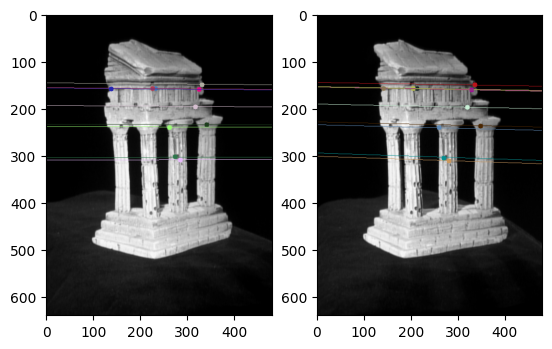

In [ ]:
draw_epipolar(img1, img2, F, pts1[:10], pts2[:10])

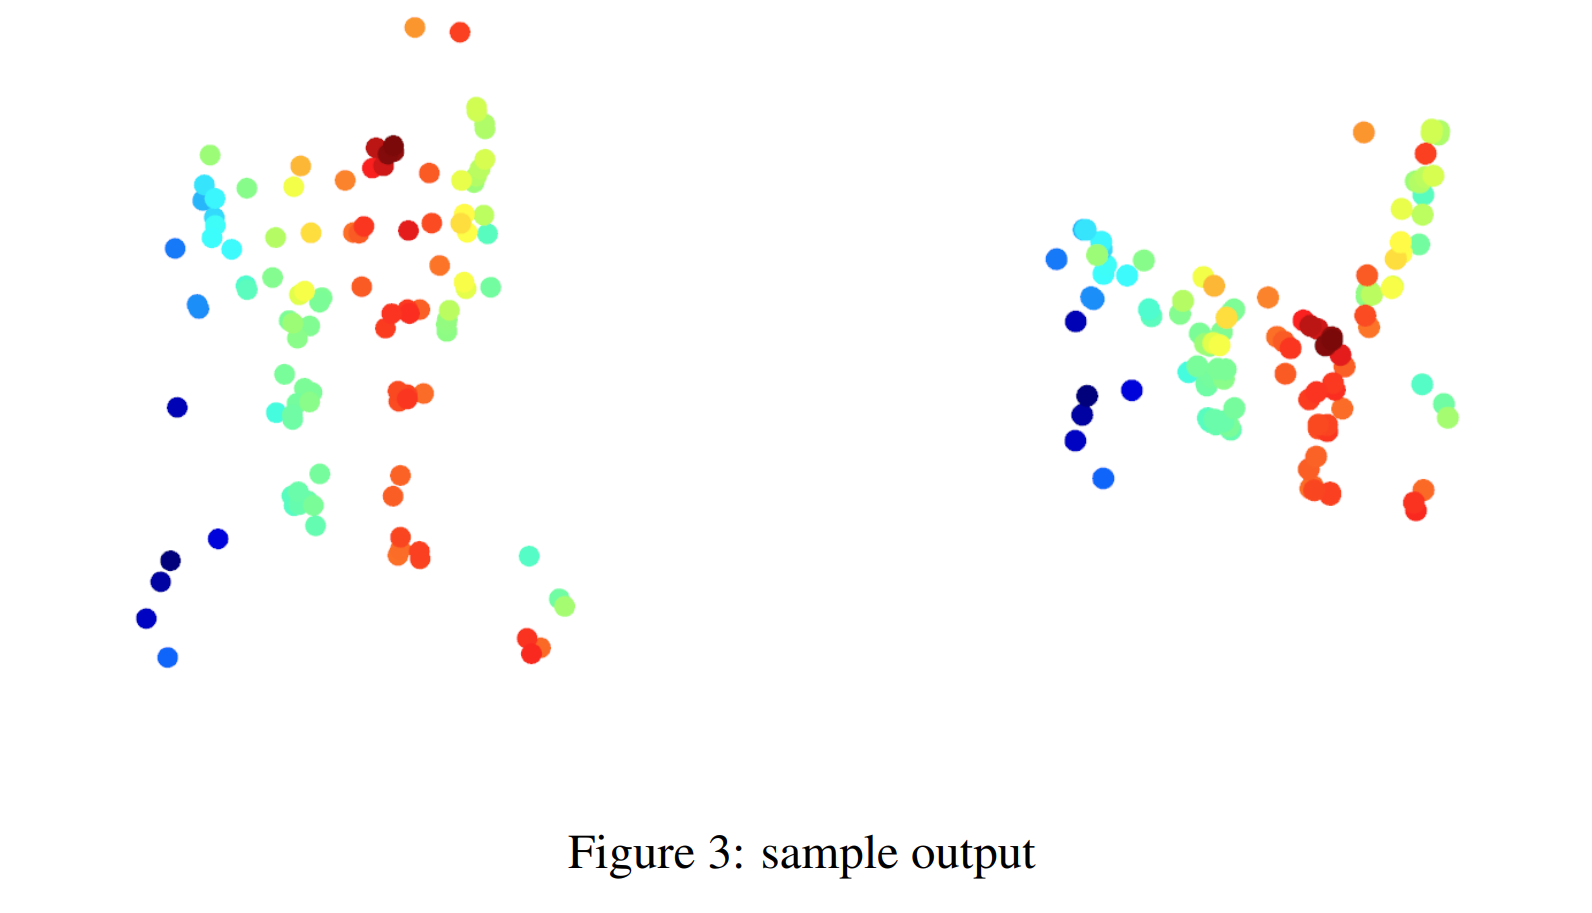

# 3 Triangulation [40 pts]

The next step is extracting 3D points from 2D points and camera matrices, which is called triangulation. Let $X = (X1, X2, X3, 1)^T$ be a point in 3D. For two cameras, we have

$$
\begin{align}
x_1 = P_1X \\
x_2 = P_2X \\
\end{align}
$$

Triangulation is to solve $X$ given $x_1, x_2, P_1, P_2$. We’ll use Direct Linear Tranform (DLT) to perform triangulation, which has already been implemented in OpenCV.

Hints:

1. Load camera intrinsic matrix $K_1$ and $K_2$ from `temple.npz`.
2. Extract the essential matrix $E$ given the fundamental matrix $F$ and intrinsic matrices $K_1$ and $K_2$. Recall that

$$
\begin{align}
F = K_2^{-T}EK_1^{-1}
\end{align}
$$

3. Decompose the essential matrix $E$ and get the rotation matrix $R$ and translation $t$. You can use `cv2.decomposeEssentialMat`. There are four possible combinations of R and t. The correct configuration is the one for which most of the 3D points are in front of both cameras (positive
depth).

4. Determine the camera projection matrices $P_1$ and $P_2$ according to the intrinsic and extrinsic matrix $[R|t]$, $K_1$ and $K_2$. Report $P_1$ and $P_2$. You can set

$$
\begin{align}
P_1 = K_1 \begin{bmatrix} I & 0 \end{bmatrix} \\
P_2 = K_2 \begin{bmatrix} R & t \end{bmatrix}
\end{align}
$$

5. Triangulate 2D pairs of points *(will be under name `pts1` and `pts2` in `temple.npz` file)* to 3D. You can use `cv2.triangulatePoints`.

6. Visualize the point cloud using `open3D`. You can use the helper method `visualize_pcd` or write your own. *Note: If displaying the projection in the colab/jupyter notebook is difficult, you may run the code in your local computer and take screenshot from 3 angles and include it in submission.*


<font color='red'>[CODE]</font> 1. Complete the function `triangulation` which will return 3D points [20 pts]

In [ ]:
# TODO

def triangulation(K1, K2, F, pts_1, pts_2): # Feel free to add as many input arguments as you like.

    # Step 2: Extract essential matrix E (also report the value of E in the answer cell below)
    E = K2.T @ F @ K1
    # print(E)
    # Step 3: Decompose E to R and T
    R, _, T = cv2.decomposeEssentialMat(E)
    # Step 4: Detemine P1 and P2 (also report the value of E in the answer cell below)
    P1 = K1 @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K2 @ np.hstack((R, T))
    # print(P1, P2)
    # Step 5:
    pts_4d = cv2.triangulatePoints(P1, P2, pts_1.T, pts_2.T)
    pts_3d = (pts_4d[:3, :]/pts_4d[3, :]).T
    return pts_3d

In [ ]:
with np.load(os.path.join(source, 'Data/temple.npz')) as temple_pts:
  pts1 = temple_pts['pts1']
  pts2 = temple_pts['pts2']
  K1 = temple_pts['K1']
  K2 = temple_pts['K2']

pts_3d = triangulation(K1, K2, F, pts1, pts2)

<font color='blue'>[ANSWER]</font> 2. Report essential matrix $E$ below [5 pts]

*Answer*

\begin{equation}
E =
\begin{bmatrix}
 -1.0551774 & 56.42814506 & 9.17409425 \\
  35.84410427 & 1.31422261 & -351.3790752 \\
 -0.79493824 & 355.80639208 & 0.42113092
\end{bmatrix}
\end{equation}

<font color='blue'>[ANSWER]</font> 3. Report $P_1$ and $P_2$ below [5 pts]

*Answer*

\begin{equation}
P_1 =
\begin{bmatrix}
 1.5204e+03 & 0 & 3.0230e+02 & 0 \\
  0 & 1.5259e+03 & 2.4690e+02 & 0 \\
 0 & 0 & 1 & 0
\end{bmatrix}
\end{equation}


\begin{equation}
P_2 =
\begin{bmatrix}
  1.50063119e+03 & 4.27188930e+01 & -3.86371055e+02 & 1.45375608e+03 \\
  2.90078424e+01 & -1.52525809e+03 & -2.49152034e+02 &  3.64493323e-01 \\
 -5.56297995e-02 & 1.65551547e-04 & -9.98451450e-01 & -1.56675614e-01
\end{bmatrix}
\end{equation}

<font color='green'>[DATA]</font> 4. Visualize the point cloud using `open3D`. You can use the helper method `visualize_pcd` or write your own. *Note: If execution of open3d in the colab/jupyter notebook is difficult, you may run the code in your local computer and take screenshot from 3 angles and include it in submission.* [10 pts]

*Answer*

Visualizations are save in images in the folder "question_3.4".


**References**

• Temple dataset. http://vision.middlebury.edu/mview/data/.

**Acknowledgement**

Part of the homework are taken from Georgia Tech CS 6476 by James Hays and CMU 16-385 and UMich EECS 442.